# Análise de dados do datasus e Wikipedia
https://datasus.saude.gov.br/informacoes-de-saude-tabnet/  

---

Procedimentos hospitalares do SUS - por local de internação - Brasil  
Valor total por Unidade da Federação e Ano/mês processamento  
Período: Jan/2008 a Ago/2020  
<br>
<br>
https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o

---

Esta é uma lista da população das unidades federativas brasileiras segundo estimativas de 1º de julho de 2020 do Instituto Brasileiro de Geografia e Estatística (IBGE).  

# Leitura e processamento inicial dos dados

In [ ]:
# imports...
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, IndexLocator
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date

# personalizando opções gerais dos módulos
pd.options.display.float_format = lambda item: f'{item:.2f}'
sns.set_style("whitegrid")

Lendo dados do datasus

In [ ]:
# url do dataset
datasus_url = 'https://raw.githubusercontent.com/LucasGabrielB/-Alura-Bootcamp-Data-Science-Aplicada/main/Modulo-01/datasets/Valor%20total%20por%20Ano-m%C3%AAs%20processamento%20segundo%20Unidade%20da%20Federa%C3%A7%C3%A3o.csv'

# criando o dataframe apartir da url do arquivo
df_datasus = pd.read_csv(datasus_url,
                 encoding='ISO-8859-1',
                 sep=';',
                 skiprows=3,
                 skipfooter=12,
                 thousands='.',
                 decimal=',',
                 engine='python',
                 na_values='-',
                 index_col='Unidade da Federação')

# removendo o codigo da UF
df_datasus.index = [' '.join(i[1:]) for i in df_datasus.index.str.split(' ')]

In [ ]:
df_datasus.head()

,2008/Jan,2008/Fev,2008/Mar,2008/Abr,2008/Mai,2008/Jun,2008/Jul,2008/Ago,2008/Set,2008/Out,2008/Nov,2008/Dez,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,2009/Nov,2009/Dez,2010/Jan,2010/Fev,2010/Mar,2010/Abr,2010/Mai,2010/Jun,2010/Jul,2010/Ago,2010/Set,2010/Out,2010/Nov,2010/Dez,2011/Jan,2011/Fev,2011/Mar,2011/Abr,...,2017/Jun,2017/Jul,2017/Ago,2017/Set,2017/Out,2017/Nov,2017/Dez,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,Total
Rondônia,1388528.39,2931283.42,1541682.52,1525314.96,1645953.84,1406150.68,3065279.01,3231494.61,3117178.63,3068430.44,2825838.52,2931173.58,2885269.07,2860103.74,3684944.68,3607289.68,3774356.60,3706711.84,3763187.55,3533625.83,3605007.43,3907032.72,3939820.71,3901084.11,3684407.02,3623015.58,3890461.90,4193533.87,4534400.67,4451208.03,4874592.78,4460802.38,5067886.24,4511092.85,4394680.50,4098741.80,4411499.48,3868617.95,4298702.78,5062171.26,...,7948291.63,8438077.45,7656644.83,8047742.98,8657206.23,8150893.68,7507845.13,7998345.94,8893683.69,8867793.32,8871408.50,8501601.67,8315107.81,8525499.78,9177611.46,7368996.38,8835095.43,8328186.64,8408512.77,9351705.82,8143007.97,8949741.77,9630553.15,9581970.31,7891114.05,9792370.67,9170787.53,8816846.71,10024554.15,9675423.70,8085025.66,9221412.18,7493310.88,8092260.11,7273843.63,7652120.28,8725530.68,11152107.08,10285455.78,929129659.72
Acre,902416.00,1497206.26,1794028.48,1730469.42,1819443.92,1828496.00,2511754.59,2089107.14,2275708.53,1923886.57,1756986.80,2235639.98,2497116.43,2253558.01,2122673.92,2834317.62,2722065.97,2432831.95,2630190.65,2307579.00,nan,2826477.02,2170791.18,2541526.44,2491042.33,1954473.90,2389996.38,2654878.60,2844085.21,2336207.19,2125143.06,2430293.67,2377738.44,2184746.84,2468452.90,2516284.54,3051370.08,2629104.42,2485451.79,2685361.47,...,2397512.85,2348760.00,3139155.41,2765062.92,4540084.78,4120228.96,2610454.55,3576595.19,2444567.37,2602434.35,3064163.42,2276236.69,3239474.10,3126429.88,2998865.51,2619709.86,3018048.94,3342614.24,2123426.26,2664654.52,1906429.95,3096439.63,2411628.00,2840630.58,3260153.59,3250722.84,3204998.88,3052745.65,3124802.29,3021521.75,2874871.28,3331803.55,3417691.07,3076003.20,2286642.60,2896340.24,3045245.80,3915193.20,nan,420668039.63
Amazonas,4735529.42,7118990.57,8196635.49,8259378.42,7831399.90,8477273.62,9368858.72,9352532.70,9363099.35,8618318.83,6555549.08,7777645.88,7403068.36,6683346.89,9927781.20,8844511.21,9079035.96,8832894.53,9373395.97,9578326.03,9730634.16,9179252.65,8314648.93,9050439.39,9419460.86,8680178.57,9168055.41,9897901.80,9651362.37,10854599.47,10417122.89,8718347.13,8221592.12,9613977.03,9927574.41,9470661.21,9736750.91,8745259.80,9380112.36,10179342.29,...,12789637.85,14376990.41,14240071.26,13594647.25,14584288.95,13158724.61,13169660.32,13572263.03,13083081.70,14322305.22,14643340.51,14632208.09,14500521.14,14840533.42,14427620.91,15818964.25,16358462.57,15391163.74,14154362.85,16791397.31,14369987.43,16339024.96,15622910.63,16483166.92,15422243.28,15961988.04,15787896.78,16515441.67,15731201.23,15744605.61,14346553.60,16018459.07,14913745.37,15068304.35,13509579.29,19658585.46,20897542.93,19346450.18,14726443.67,1771654871.23
Roraima,657889.53,777939.31,718688.03,839994.39,862347.96,832440.66,996693.09,894271.18,910424.17,1191770.32,1056218.71,1244339.25,1085679.25,969528.54,1393226.70,1273734.17,1552638.50,1490587.74,1596751.80,1848998.68,1701611.25,1164711.18,1434809.17,1603817.28,1437340.80,1332094.01,1900513.75,1933875.49,1773958.29,1804729.73,1846639.32,1643518.23,1843163.29,1807885.17,1674871.65,1250999.28,1257275.43,1171045.72,1389668.67,1344865.94,...,2755620.24,2878177.60,2921978.36,2794080.79,2512259.50,2508514.18,2635287.45,2914195.21,2881281.13,2740423.51,2695484.62,261

Lendo dados da Wikipedia

In [ ]:
# url da pagina
wikipedia_url = 'https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o'

# extraindo o dataframe apartir da url da pagina
df_wikipedia = pd.read_html(wikipedia_url)[0]
df_wikipedia = df_wikipedia[['Unidade federativa', 'População']]
df_wikipedia.set_index('Unidade federativa', inplace=True)

# convertendo os valores
df_wikipedia['População'] = df_wikipedia['População'].str.replace(' ', '').astype(int)

In [ ]:
df_wikipedia.head()

,População
Unidade federativa,
São Paulo,46289333
Minas Gerais,21331292
Rio de Janeiro,17366189
Bahia,14930634
Paraná,11516840


# Análise de dados 


In [ ]:
# dataframe com os gastos mensais
df_datasus_monthly = df_datasus.drop('Total', axis=1).T

def str_to_date(date_str: str) -> date:
    ''' converte uma string no formato "yyyy/[nome_mes_abreviado]" para uma data '''

    conversion_dict = {
        'Jan': 1,
        'Fev': 2,
        'Mar': 3,
        'Abr': 4,
        'Mai': 5,
        'Jun': 6,
        'Jul': 7,
        'Ago': 8,
        'Set': 9,
        'Out': 10,
        'Nov': 11,
        'Dez': 12,
    }
    
    year, month = date_str.split('/')
    month = conversion_dict[month]

    return date(int(year), month, 1)


# converte o indice para datas
df_datasus_monthly.index = df_datasus_monthly.index.map(str_to_date)

In [ ]:
df_datasus_monthly.head()

,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
2008-01-01,1388528.39,902416.00,4735529.42,657889.53,18864744.11,1120973.34,3441592.69,10723506.39,7985142.43,15539821.90,5947814.08,10723002.45,14393949.89,6243726.32,2780750.11,21211522.47,45671659.76,5456723.98,23025258.52,91678473.48,38266347.46,16504913.45,30931325.46,5377392.11,4795299.01,15310637.29,4745919.19
2008-02-01,2931283.42,1497206.26,7118990.57,777939.31,19553758.20,1268740.33,4985688.85,13559679.41,10079928.25,25735101.55,9509755.83,11386274.47,24181400.95,8376622.16,3676483.16,28189304.95,70194037.10,9102212.86,28394310.93,148677526.82,55384670.52,25651429.11,57363420.01,7002472.61,8684882.23,22258668.68,7632480.67
2008-03-01,1541682.52,1794028.48,8196635.49,718688.03,21937342.70,974651.24,6205612.60,13985142.36,10298372.45,28724625.75,10352238.59,12053643.87,29991302.71,8408336.22,5051473.61,34181483.52,79231336.95,10249595.97,44567062.94,156087269.23,53801318.85,26743524.89,51547794.07,8423933.19,7886243.14,21442515.75,9647203.26
2008-04-01,1525314.96,1730469.42,8259378.42,839994.39,20842829.69,1141137.32,4984482.09,14809416.46,10775976.33,30676457.06,10855108.50,12653528.76,34806197.97,9090794.82,5046063.36,39026934.13,77136537.58,11253833.56,44054604.82,161227125.43,52460306.69,27181488.26,56673338.49,8797487.68,8794109.79,20921212.45,11098732.99
2008-05-01,1645953.84,1819443.92,7831399.90,862347.96,23249952.88,866346.18,5511002.46,14505727.38,10398360.88,30604453.47,11160168.19,12215107.11,32147987.35,9338771.45,4741151.56,42949566.82,80554440.63,10198619.17,44911021.15,187119397.64,54419620.71,26845308.18,48397733.07,9770421.80,9231645.40,21615970.67,12891719.72


In [ ]:
df_datasus_monthly_melt = df_datasus_monthly.reset_index().melt(id_vars=['index']).set_index('index')
df_datasus_monthly_melt.columns = ['UF', 'Gasto']
df_datasus_monthly_melt.dropna(inplace=True)
df_datasus_monthly_melt.sort_values(by=['Gasto'], inplace=True, ascending=False)

In [97]:
df_datasus_monthly_melt

,UF,Gasto
index,,
2020-07-01,São Paulo,366721243.71
2020-08-01,São Paulo,346512263.17
2019-08-01,São Paulo,313868712.55
2019-10-01,São Paulo,310847061.00
2020-06-01,São Paulo,306425499.30
...,...,...
2008-04-01,Roraima,839994.39
2008-06-01,Roraima,832440.66
2008-02-01,Roraima,777939.31


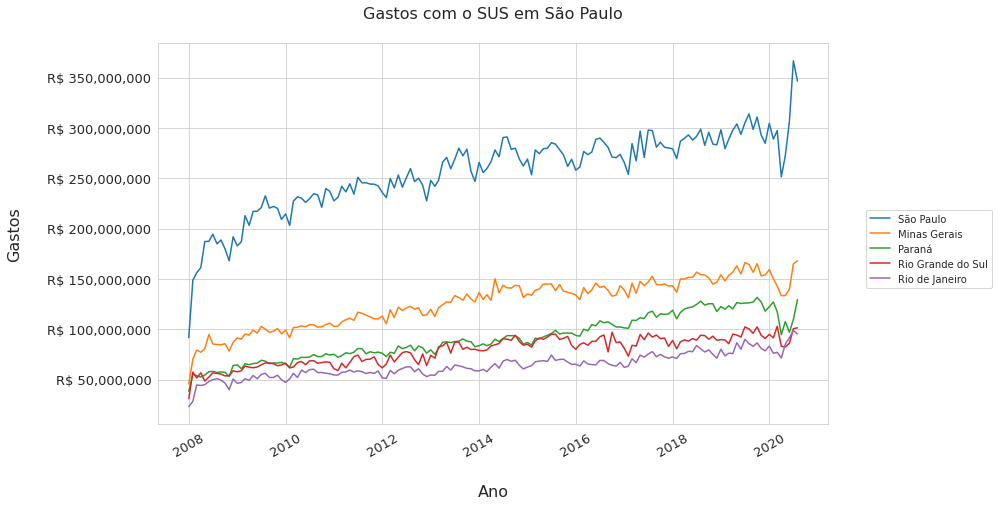

In [96]:
# dataframe apenas com 5 estados
df_temp = df_datasus_monthly_melt.query('UF == ["São Paulo", "Minas Gerais", "Paraná", "Rio Grande do Sul", "Rio de Janeiro"]')

plt.figure(figsize=(12, 7))
ax = sns.lineplot(data=df_temp,
                  x=df_temp.index,
                  y='Gasto',
                  hue='UF')

# personalizando os graficos
ax.yaxis.set_major_formatter(StrMethodFormatter('R$ {x:,.0f}'))
plt.title('Gastos com o SUS em São Paulo', pad=25, fontsize=16)
plt.ylabel('Gastos', labelpad=25, fontsize=16)
plt.xlabel('Ano', labelpad=25, fontsize=16)
plt.xticks(rotation=30)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.46), ncol=1)

 
plt.show()

Revertendo o efeito do .melt():

In [101]:
df_datasus_monthly_melt.reset_index().pivot(index='UF', columns=['index'])

Gasto               ...                          
index                2008-01-01   2008-02-01  ...   2020-07-01   2020-08-01
UF                                            ...                          
Acre                  902416.00   1497206.26  ...   3915193.20          nan
Alagoas              6243726.32   8376622.16  ...  18351680.84  19754741.78
Amapá                1120973.34   1268740.33  ...   3249565.87   2942273.94
Amazonas             4735529.42   7118990.57  ...  19346450.18  14726443.67
Bahia               21211522.47  28189304.95  ...  83992134.91  80793117.08
Ceará               15539821.90  25735101.55  ...  55180751.48  59808605.59
Distrito Federal     4745919.19   7632480.67  ...  25269773.34  26526196.39
Espírito Santo       5456723.98   9102212.86  ...  33290880.33  32188873.88
Goiás               15310637.29  22258668.68  ...  39405050.36  43984702.05
Maranhão            10723506.39  13559679.41  ...  32936503.37  28587541.78
Mato Grosso          4795299.01   8684882.23  ...  16371639.49  17790649.87
Mato Grosso do Sul   5377392.11   7002472.61  ...  18755557.92  19241624.02
Minas Gerais        45671659.76  70194037.10  ... 164891823.64 168024412.95
Paraná              38266347.46  55384670.52  ... 109658360.43 129375911.54
Paraíba             10723002.45  11386274.47  ...  26902438.72  22130016.81
Pará                18864744.11  19553758.20  ...  38438873.79  39911193.02
Pernambuco          14393949.89  24181400.95  ...  74192800.58  75704177.72
Piauí                7985142.43  10079928.25  ...  17871598.61  23210624.20
Rio Grande do Norte  5947814.08   9509755.83  ...  26302373.94  24929930.72
Rio Grande do Sul   30931325.46  57363420.01  ... 100531035.83 101374341.51
Rio de Janeiro      23025258.52  28394310.93  ...  98722687.54  95274486.35
Rondônia             1388528.39   2931283.42  ...  11152107.08  10285455.78
Roraima               657889.53    777939.31  ...   3015488.30   2826486.18
Santa Catarina      16504913.45  25651429.11  ...  63467828.84  63972379.36
Sergipe              2780750.11   3676483.16  ...  10313262.56  11014180.89
São Paulo           91678473.48 148677526.82  ... 366721243.71 346512263.17
Tocantins            3441592.69   4985688.85  ...   9131707.60   8240261.38

[27 rows x 152 columns]